<a href="https://colab.research.google.com/github/vlad-danaila/ml-cancer-detection/blob/master/Cancer_Detection_Ensable_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download dependencies**

In [0]:
!pip3 install sklearn matplotlib GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=f2ec06ee75e3619d1601b9d0632402a12e7633192f53ddf8e5345ebb6cfa001e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [0]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 621.4MB 72kB/s s eta 0:00:01     |███████████████▎                | 296.4MB 85.9MB/s eta 0:00:04     |███████████████▉                | 306.9MB 85.9MB/s eta 0:00:04     |███████████████████▋            | 380.5MB 52.0MB/s eta 0:00:05     |████████████████████▊           | 403.0MB 52.0MB/s eta 0:00:05     |████████████████████████▋       | 478.5MB 2.7MB/s eta 0:00:53     |██████████████████████████      | 504.5MB 2.7MB/s eta 0:00:44
     |████████████████████████████████| 10.1MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 12.6MB/s eta 0:00:01


**Download Data**

Mount my google drive, where I stored the dataset.

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print(e)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In order to acquire the dataset please navigate to:

https://ieee-dataport.org/documents/cervigram-image-dataset

Unzip the dataset into the folder "dataset".

For your environment, please adjust the paths accordingly.

In [0]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
# !cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

Archive:  dataset/cervigram-image-dataset-v2.zip
   creating: dataset/data/
   creating: dataset/data/test/
   creating: dataset/data/test/0/
   creating: dataset/data/test/0/20151103002/
  inflating: dataset/data/test/0/20151103002/20151103113458.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113637.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113659.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113722.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113752.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113755.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113833.jpg  
   creating: dataset/data/test/0/20151103005/
  inflating: dataset/data/test/0/20151103005/20151103161719.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161836.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161908.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161938.jpg  
  inflating: dataset/data/test/0/2015110

**Constants**

For your environment, please modify the paths accordingly.  

In [0]:
TRAIN_PATH = '/content/dataset/data/train/'
TEST_PATH = '/content/dataset/data/test/'
# TRAIN_PATH = 'dataset/data/train/'
# TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 100

prefix = '/content/drive/My Drive/Studiu doctorat leziuni cervicale/V2/Chekpoints & Notebooks/'
CHECKPOINT_NATURAL_IMG_MODEL = prefix + 'Cancer Detection MobileNetV2 All Natural Images Full Conv32-0.7 6 Dec.tar'
CHECKPOINT_GREEN_LENS_IMG_MODEL = prefix + 'Cancer_Detection_MobileNetV2_Green_Lens_2_Dec Full Conv 64 0.7.tar'
CHECKPOINT_IODINE_SOLUTION_IMG_MODEL = prefix + 'Cancer_Detection_MobileNetV2_Iodine_1_Dec Full Conv32.tar'

**Imports**

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random

**Deterministic Measurements**

This statements help making the experiments reproducible by fixing the random seeds. Despite fixing the random seeds, experiments are usually not reproducible using different PyTorch releases, commits, platforms or between CPU and GPU executions. Please find more details in the PyTorch documentation:

https://pytorch.org/docs/stable/notes/randomness.html

In [0]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Memory Stats**

In [0]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 3340MB | Used: 4271MB | Util  56% | Total 7611MB


**Loading Data**

The dataset is structured in multiple small folders of 7 images each. This generator iterates through the folders and returns the category and 7 paths: one for each image in the folder. The paths are ordered; the order is important since each folder contains 3 types of images, first 5 are with acetic acid solution and the last two are through a green lens and having iodine solution(a solution of a dark red color).

In [0]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define 4 datasets, which load: natural images, images taken through a green lens, images where the doctor applied iodine solution (which gives a dark red color) and all images. Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data.

In [0]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class TransformsRand:
  def __init__(self):
    self.angle = random.random()
    self.scale = random.random()
    self.shear = random.random()
    self.hflip = random.random()
        
class AllImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None, is_train = True):
    self.is_train = is_train
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      imgs = []
      for i in range(7):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        imgs.append(img)
      if transforms_y_static != None:
        category = transforms_y_static(category)
      self.dataset.append((imgs, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      if self.is_train:
        rand = TransformsRand()
        x = [self.transforms_x(_x, rand = rand) for _x in x]
#         x = [self.transforms_x(_x) for _x in x]
      else:
        x = [self.transforms_x(_x) for _x in x]
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

**Preprocess Data**

Convert pytorch tensor to numpy array.

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [0]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

def custom_transforms(x, angle = 45, scale = (1., 2.), shear = 30, rand = None):
    if rand == None:
        rand = TransformsRand()
    angle = angle * rand.angle
    scale_value = scale[0] + ((scale[1] - scale[0]) * rand.scale)
    shear = shear * rand.shear
    x = tv.transforms.functional.affine(x, angle = angle, scale = scale_value, shear = shear, translate = [0, 0])
    x = tv.transforms.functional.resize(x, IMAGE_SIZE)
    if rand.hflip > .5:
        x = tv.transforms.functional.hflip(x)
    x = tv.transforms.functional.to_tensor(x).cuda()
    x = tv.transforms.functional.normalize(x, mean=norm_mean, std=norm_std)
    return x

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize pytorch datasets and loaders for training and test.

In [0]:
def create_loaders():
  dataset_train = AllImagesDataset(TRAIN_PATH, transforms_x_dynamic = custom_transforms, transforms_y_dynamic = y_transform)
  dataset_test = AllImagesDataset(TEST_PATH, transforms_x_static = transforms_test, 
        transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform, is_train = False)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [0]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders()

**Visualize Data**

Load a few images so that we can see the effects of the data augmentation on the training set.

In [0]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [0]:
# x, y = next(iter(loader_train_simple_img))
# for i in range(7):
#   plot_predictions(x[i], y, y)

**Model**

Define a few models to experiment with.

In [0]:
def get_mobilenet_v2():
  model = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
  model.classifier[0] = t.nn.Dropout(p=0.9, inplace=False)
  model.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  model.features[18].add_module('cnn_drop_18', t.nn.Dropout2d(p = .3))
  model.features[17]._modules['conv'][1].add_module('cnn_drop_17', t.nn.Dropout2d(p = .2))
  model.features[16]._modules['conv'][1].add_module('cnn_drop_16', t.nn.Dropout2d(p = .1))
  model = model.cuda()
  return model

def get_vgg_19():
  model = tv.models.vgg19(pretrained = True)
  model = model.cuda()
  model.classifier[2].p = .9
  model.classifier[6].out_features = 4
  return model

def get_res_next_101():
  model = t.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=2048, out_features=4)
  )
  model = model.cuda()
  return model

def get_resnet_18():
  model = tv.models.resnet18(pretrained = True)
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=512, out_features=4)
  )
  model = model.cuda()
  return model

def get_dense_net():
  model = tv.models.densenet121(pretrained = True)
  model.classifier = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features = 1024, out_features = 4)
  )
  model = model.cuda()
  return model

Define ensemble.

In [0]:
class WrappedModel(t.nn.Module):
	def __init__(self, module):
		super().__init__()
		self.module = module # that I actually define.
	def forward(self, x):
		return self.module(x)

class MobileNetV2_FullConv(t.nn.Module):
  def __init__(self, end_channels):
    super().__init__()
    self.cnn = get_mobilenet_v2().features
    self.cnn[18] = t.nn.Sequential(
      tv.models.mobilenet.ConvBNReLU(320, end_channels, kernel_size=1)
    )
    self.fc = t.nn.Linear(end_channels, 4)

  def forward(self, x):
    x = self.cnn(x)
    x = x.mean([2, 3])
    x = self.fc(x);
    return x
    
class Ensamble(t.nn.Module):
  def __init__(self):
    super().__init__()
    self.model_simple = cnn_full_conv(CHECKPOINT_NATURAL_IMG_MODEL, 32).cnn
    self.model_green = cnn_full_conv(CHECKPOINT_GREEN_LENS_IMG_MODEL, 64).cnn
    self.model_red = cnn_full_conv(CHECKPOINT_IODINE_SOLUTION_IMG_MODEL, 32).cnn
    channels = 32 * 5 + 64 + 32
    fc_size = 32
    self.classifier = tv.models.mobilenet.InvertedResidual(inp = channels, oup = fc_size, stride = 1, expand_ratio = 5)
    self.classifier._modules['conv'][0].add_module('classifier_drop_1', t.nn.Dropout2d(p = .6))
    self.classifier._modules['conv'][1].add_module('classifier_drop_1', t.nn.Dropout2d(p = .6))
    self.fc = t.nn.Sequential(
        # t.nn.Dropout(p = .2),
        t.nn.Linear(fc_size, 4)
    )

  def forward(self, x):
    x_list = []
    for i in range(5):
      x_list.append(self.model_simple(x[i]))
    x_list.append(self.model_green(x[5]))
    x_list.append(self.model_red(x[6]))
    x_concat = t.cat(x_list, 1)
    x_concat = self.classifier(x_concat)
    x_concat = x_concat.mean([2, 3])
    x_concat = self.fc(x_concat)
    return x_concat

def cnn(checkpoint_path):
  cnn = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)
  cnn.classifier[0] = t.nn.Dropout(p=0, inplace=False)
  cnn.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  checkpoint = t.load(checkpoint_path)
  cnn.load_state_dict(checkpoint['model'])
  for param in cnn.parameters():
    param.requires_grad = False
  return cnn

def cnn_from_data_parallel(checkpoint_path):
  cnn = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)
  cnn.classifier[0] = t.nn.Dropout(p=0, inplace=False)
  cnn.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  cnn = WrappedModel(cnn)
  checkpoint = t.load(checkpoint_path)
  cnn.load_state_dict(checkpoint['model'])
  for param in cnn.parameters():
    param.requires_grad = False
  return cnn

def cnn_full_conv(checkpoint_path, end_channels_nb):  
  cnn = MobileNetV2_FullConv(end_channels_nb)
  checkpoint = t.load(checkpoint_path)
  cnn.load_state_dict(checkpoint['model'])
  for param in cnn.parameters():
    param.requires_grad = False
  return cnn

In [0]:
model_simple = t.nn.DataParallel(Ensamble().cuda())

Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master


**Train & Evaluate**

Timer utility function. This is used to measure the execution speed.

In [0]:
time_start = 0

def timer_start():
  global time_start
  time_start = time.time()

def timer_end():
  return time.time() - time_start

This function trains the network and evaluates it at the same time. It outputs the metrics recorded during the training for both train and test. We are measuring accuracy and the loss. The function also saves a checkpoint of the model every time the accuracy is improved. In the end we will have a checkpoint of the model which gave the best accuracy.

In [0]:
def train_eval(optimizer, model, loader_train, loader_test, chekpoint_name, epochs):
  metrics = {
      'losses_train': [],
      'losses_test': [],

      'acc_train': [],
      'acc_test': [],

      'prec_train': [],
      'prec_test': [],

      'rec_train': [],
      'rec_test': [],

      'f_score_train': [],
      'f_score_test': []
  }

  best_acc = 0
  
  loss_fn = t.nn.CrossEntropyLoss()
    
  try:  
    for epoch in range(epochs):
      timer_start()
      train_epoch_loss, train_epoch_acc, train_epoch_precision, train_epoch_recall, train_epoch_f_score = 0, 0, 0, 0, 0
      test_epoch_loss, test_epoch_acc, test_epoch_precision, test_epoch_recall, test_epoch_f_score = 0, 0, 0, 0, 0

      # Train
      model.train()
      for x, y in loader_train:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
#         memory_stats()
        optimizer.zero_grad()
        y_pred, y = to_numpy(y_pred), to_numpy(y)
        pred = y_pred.argmax(axis = 1)
        ratio = len(y) / len_train
        train_epoch_loss += (loss.item() * ratio)
        train_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio)
        precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
        train_epoch_precision += (precision * ratio)
        train_epoch_recall += (recall * ratio)
        train_epoch_f_score += (f_score * ratio)
      metrics['losses_train'].append(train_epoch_loss)
      metrics['acc_train'].append(train_epoch_acc)
      metrics['prec_train'].append(train_epoch_precision)
      metrics['rec_train'].append(train_epoch_recall)
      metrics['f_score_train'].append(train_epoch_f_score)
  
      # Evaluate
      model.eval()
      with t.no_grad():
        for x, y in loader_test:
          y_pred = model.forward(x)
          loss = loss_fn(y_pred, y)
          y_pred, y = to_numpy(y_pred), to_numpy(y)
          pred = y_pred.argmax(axis = 1)
          ratio = len(y) / len_test
          test_epoch_loss += (loss * ratio)
          test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
          precision, recall, f_score, _ = sk.metrics.precision_recall_fscore_support(y, pred, average = 'macro')
          test_epoch_precision += (precision * ratio)
          test_epoch_recall += (recall * ratio)
          test_epoch_f_score += (f_score * ratio)
        metrics['losses_test'].append(test_epoch_loss)
        metrics['acc_test'].append(test_epoch_acc)
        metrics['prec_test'].append(test_epoch_precision)
        metrics['rec_test'].append(test_epoch_recall)
        metrics['f_score_test'].append(test_epoch_f_score)
      
      if metrics['acc_test'][-1] > best_acc:
        best_acc = metrics['acc_test'][-1]
        t.save({'model': model.state_dict()}, 'checkpint {}.tar'.format(chekpoint_name))
      print('Epoch {} acc {} prec {} rec {} f {} minutes {}'.format(
        epoch + 1, metrics['acc_test'][-1], metrics['prec_test'][-1], metrics['rec_test'][-1], metrics['f_score_test'][-1], timer_end() / 60))
  except KeyboardInterrupt as e:
    print(e)  
  print('Ended training')
  return metrics

Plot a metric for both train and test.

In [0]:
def plot_train_test(train, test, title, y_title):
    plt.plot(range(len(train)), train, label = 'train')
    plt.plot(range(len(test)), test, label = 'test')
    plt.xlabel('Epochs')
    plt.ylabel(y_title)
    plt.title(title)
    plt.legend()
    plt.show()

In [0]:
def plot_precision_recall(metrics):
    plt.scatter(metrics['prec_train'], metrics['rec_train'], label = 'train')
    plt.scatter(metrics['prec_test'], metrics['rec_test'], label = 'test')
    plt.legend()
    plt.title('Precision-Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

Train a model for several epochs. The steps_learning parameter is a list of tuples. Each tuple specifies the steps and the learning rate.

In [0]:
def do_train(model, loader_train, loader_test, checkpoint_name, steps_learning):
  t.cuda.empty_cache()
  for steps, learn_rate in steps_learning:
    metrics = train_eval(t.optim.Adam(model.parameters(), lr = learn_rate, weight_decay = 0), model, loader_train, loader_test, checkpoint_name, steps)
    
    index_max = np.array(metrics['acc_test']).argmax()
    print('Best test accuracy :', metrics['acc_test'][index_max])
    print('Corresponding precision :', metrics['prec_test'][index_max])
    print('Corresponding recall :', metrics['rec_test'][index_max])
    print('Corresponding f1 score :', metrics['f_score_test'][index_max])

    plot_train_test(metrics['losses_train'], metrics['losses_test'], 'Loss (lr = {})'.format(learn_rate), 'Loss')
    plot_train_test(metrics['acc_train'], metrics['acc_test'], 'Accuracy (lr = {})'.format(learn_rate), 'Accuracy')
    plot_train_test(metrics['prec_train'], metrics['prec_test'], 'Precision (lr = {})'.format(learn_rate), 'Precision')
    plot_train_test(metrics['rec_train'], metrics['rec_test'], 'Recall (lr = {})'.format(learn_rate), 'Recall')
    plot_train_test(metrics['f_score_train'], metrics['f_score_test'], 'F1 Score (lr = {})'.format(learn_rate), 'F1 Score')
    plot_precision_recall(metrics)

Perform actual training.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1 acc 0.3125 prec 0.5666666666666667 rec 0.3125 f 0.21515326778484675 minutes 0.36292420625686644
Epoch 2 acc 0.5 prec 0.4698275862068966 rec 0.5 f 0.44335686777920413 minutes 0.3613640149434408
Epoch 3 acc 0.6666666666666666 prec 0.7070585664335665 rec 0.6666666666666666 f 0.6746273291925466 minutes 0.3582398295402527


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch 4 acc 0.7291666666666666 prec 0.7440476190476191 rec 0.7291666666666666 f 0.7336829836829837 minutes 0.3602852702140808
Epoch 5 acc 0.75 prec 0.7734036796536796 rec 0.7500000000000001 f 0.7506534126099343 minutes 0.3601437528928121
Epoch 6 acc 0.7708333333333334 prec 0.8020833333333333 rec 0.7708333333333334 f 0.7726430976430977 minutes 0.3598912795384725
Epoch 7 acc 0.7291666666666666 prec 0.8027777777777778 rec 0.7291666666666666 f 0.7309523809523809 minutes 0.3615299661954244
Epoch 8 acc 0.7708333333333334 prec 0.8258547008547008 rec 0.7708333333333334 f 0.7748165869218501 minutes 0.35930830240249634
Epoch 9 acc 0.8125 prec 0.8504464285714286 rec 0.8125 f 0.8120772248346619 minutes 0.3597938378651937
Epoch 10 acc 0.7916666666666666 prec 0.8403361344537815 rec 0.7916666666666667 f 0.7934461183100021 minutes 0.3592311541239421
Epoch 11 acc 0.7916666666666666 prec 0.8385416666666666 rec 0.7916666666666667 f 0.7930970102022734 minutes 0.3576032320658366
Epoch 12 acc 0.8125 prec 0.

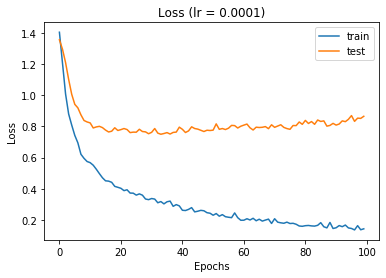

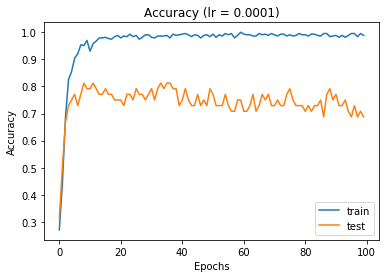

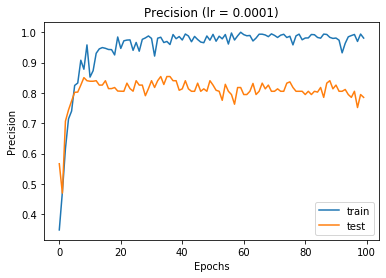

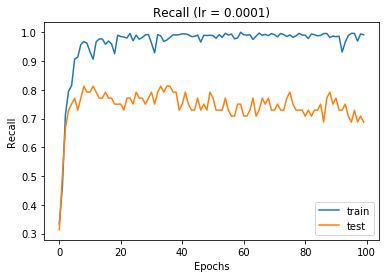

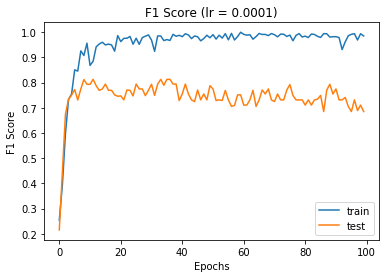

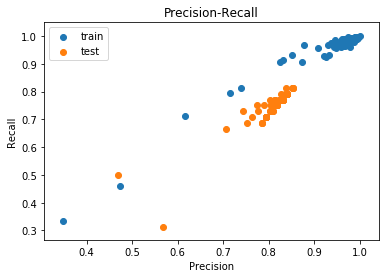

In [0]:
do_train(model_simple, loader_train_simple_img, loader_test_simple_img, 'simple_1', [(100, 1e-4)])

Utility function to perform evaluation without going through training, useful for checking models loaded through checkpoints.

In [0]:
def evaluate(model, loader_test, len_test):
  metrics = {
      'losses_test': [],
      'acc_test': []
  }
  best_acc = 0
  loss_fn = t.nn.CrossEntropyLoss()
  test_epoch_acc, test_epoch_loss = 0, 0

  model.eval()
  with t.no_grad():
    conf_matrix = np.zeros((4, 4))
    for x, y in loader_test:
      y_pred = model.forward(x)
      loss = loss_fn(y_pred, y)
      y_pred, y = to_numpy(y_pred), to_numpy(y)
      pred = y_pred.argmax(axis = 1)
      ratio = len(y) / len_test
      test_epoch_loss += (loss * ratio)
      test_epoch_acc += (sk.metrics.accuracy_score(y, pred) * ratio )
      cm = sk.metrics.confusion_matrix(y, pred, labels = list(range(4)))
      conf_matrix += cm
    metrics['losses_test'].append(test_epoch_loss)
    metrics['acc_test'].append(test_epoch_acc)
    print('Confusion matrix:\n', conf_matrix)
    errors = [sum(conf_matrix[i]) - conf_matrix[i][i] for i in range(len(conf_matrix))]
    print('Error distribution:\n', errors)
    
    error_distribution = [e / sum(errors) for e in errors]
    plt.bar(list(range(4)), error_distribution, align='center', alpha=0.5)
    plt.xticks(list(range(4)), list(range(4)))
    plt.xlabel('Classes')
    plt.ylabel('Error percentage')
    plt.show()
    
    print('Acc {}'.format(metrics['acc_test'][-1]))
  print('Ended training\n')  
  return metrics